In [143]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pprint
import json
import random

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import shap
import matplotlib
shap.initjs()

# Data Setup
## Read & Preprocess

In [3]:
df = pd.read_csv("dataset_students.csv")
df["target_binary"] = (df["Target"] == "Graduate")
df = df[df["Target"] != "Enrolled"]
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,target_binary
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,False
1,1,6,1,11,1,1,1,1,3,4,...,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,True
2,1,1,5,5,1,1,1,22,27,10,...,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,False
3,1,8,2,15,1,1,1,23,27,6,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,True
4,2,12,1,3,0,1,1,22,28,10,...,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate,True
4420,1,1,2,15,1,1,19,1,1,10,...,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout,False
4421,1,1,1,12,1,1,1,22,27,10,...,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout,False
4422,1,1,1,9,1,1,1,22,27,8,...,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate,True


In [163]:
with open('dataset_values.txt', 'r') as file:
    # Read all the lines of the file into a list
    file_content = file.read()

conversion = {}

file_content = file_content.split("+++\n")
categories = []
for cat in file_content:
    cat = [c.strip() for c in cat.split("\n") if not c.strip() == ""]
    categories.append(cat)

for cat in categories:
    conversion[cat[0]] = {"name":cat[1]}
    if len(cat)==2:
        conversion[cat[0]]["convertible"] = False
    else:
        conversion[cat[0]]["convertible"] = True
        values = cat[2:]
        for v in values:
            i_split = v.index("-")
            conversion[cat[0]][int(v[:i_split])] = v[i_split+1:]

pprint.pprint(conversion)

{'Age at enrollment': {'convertible': False, 'name': 'Age at enrollment'},
 'Application mode': {1: '1st phase-general contingent',
                      2: 'Ordinance No. 612/93',
                      3: '1st phase-special contingent (Azores Island)',
                      4: 'Holders of other higher courses',
                      5: 'Ordinance No. 854-B/99',
                      6: 'International student (bachelor)',
                      7: '1st phase-special contingent (Madeira Island)',
                      8: '2nd phase-general contingent',
                      9: '3rd phase-general contingent',
                      10: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
                      11: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
                      12: 'Over 23 years old',
                      13: 'Transfer',
                      14: 'Change in course',
                      15: 'Technological specialization diploma holders',
                     

## X/Y Train/Test Split

In [6]:
X = df.drop(["Target", "target_binary"], axis = 1)
X.shape

(3630, 34)

In [10]:
# optionally: reduce features e.g. to not have info on second or end-of-first semester performance

reduce = False
if reduce:
    X_reduced = X.copy()
    X_reduced = X_reduced.drop("Curricular units 1st sem (evaluations)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 1st sem (approved)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 1st sem (grade)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 1st sem (without evaluations)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 2nd sem (credited)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 2nd sem (enrolled)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 2nd sem (evaluations)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 2nd sem (approved)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 2nd sem (grade)", axis = 1)
    X_reduced = X_reduced.drop("Curricular units 2nd sem (without evaluations)", axis = 1)

In [7]:
y = df["target_binary"]
y.shape

(3630,)

In [20]:
# train set is relatively small (0.3 of original set), in order to reduce model performance somewhat

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.5)#, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.6)#, random_state=0)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)
d_val = lgb.Dataset(X_val, label=y_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1089, 34)
(726, 34)
(1815, 34)


# Model & Explanator

## Setup & Train LightGBM Model

In [21]:
params = {
    "max_bin": 127,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 8,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_val],
)

# save model
model.save_model('model.txt')

# load saved model
# model = lgb.Booster(model_file='model.txt')  # init model

## Check Model Performance

In [23]:
y_pred = model.predict(X_test)#, num_iteration=model.best_iteration)
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 0.2816915535227657


In [25]:
y_pred_binary = y_pred >= 0.5

print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))

[[ 578  134]
 [  52 1051]]
              precision    recall  f1-score   support

       False       0.92      0.81      0.86       712
        True       0.89      0.95      0.92      1103

    accuracy                           0.90      1815
   macro avg       0.90      0.88      0.89      1815
weighted avg       0.90      0.90      0.90      1815



## Shap Explanator

In [26]:
explainer = shap.TreeExplainer(model, data = X_test, 
                               feature_perturbation="interventional", model_output="probability")

shap_values = explainer(X_test)

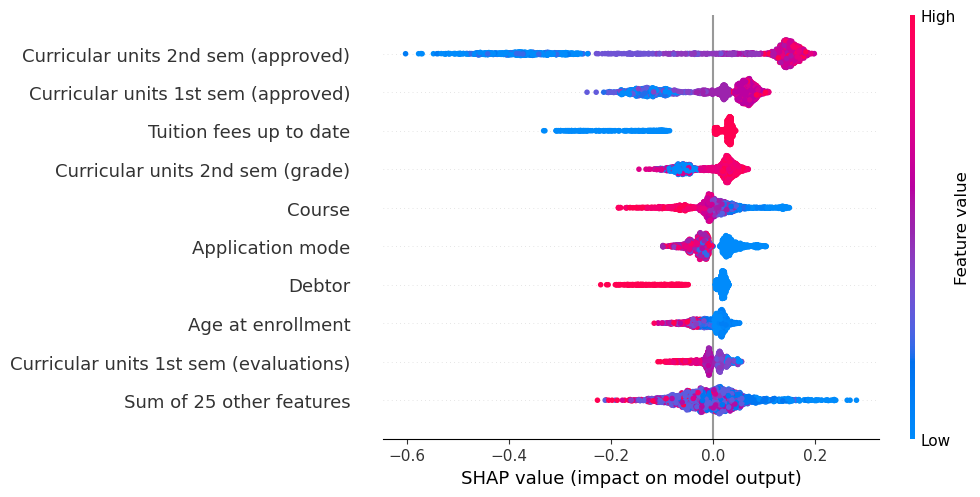

In [27]:
shap.plots.beeswarm(shap_values)

# Visual Explanation

## Methods

In [138]:
def print_example(student_example, cutoff = 0.01, id = -1):

    if id == -1:
        id = str(student_example["id_raw"]) + " [raw]"

    text = ""
    text += "Student " + str(id)
    text += "\n\nPredicted likelihood to graduate: " + str(student_example["grad_chance"])
    #text += "\nBase chance: " + str(explainer.expected_value)
    text += "\n\nFactors: "

    sum_chance = 0
        
    for f in student_example["features"]:
        if abs(f[2])>cutoff:
            text += "\n" + f[0] + ": " + str(f[1]) + "\t" + str(f[2])
        sum_chance += f[2]

    print(text)
    return text

    #print(sum_chance, sum_chance + explainer.expected_value)

In [157]:
def visualize_example(student_example, cutoff = 0.01, save = False, id = -1):

    c_good = "#0c7bdc" #"#005ab5"
    c_bad = "#e66100" #"#ffc20a" #"#dc3220"
    c_base = "#7ccbfc"

    base = explainer.expected_value#-0.5
    likelihood = student_example["grad_chance"]# - 0.5
    missing_likelihood = likelihood - (sum([f[2] for f in student_example["features"]]) + base)

    c_other = c_good if missing_likelihood > 0 else c_bad
    c_grad = c_good if likelihood-0.5 > 0 else c_bad

    data_x = [base-0.5]
    colors = [c_base]
    for f in student_example["features"]:
        if abs(f[2])>cutoff:
            data_x.append(f[2])
            colors.append(c_good if f[2]>cutoff else c_bad)

    data_x += [missing_likelihood]
    colors += [c_other]
    data_y = range(len(data_x))
    
    fig, ax = plt.subplots(figsize = (13,8))

    ax.barh(data_y, data_x, align='center', color=colors, height = 0.7)
    ax.set_xlim(-0.5,1.5)
    ax.set_ylim(-1,30)
    ax.invert_yaxis() 
    
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    for i, f in enumerate([f for f in student_example["features"] if abs(f[2])>cutoff]):
        text = str(f[0])+": "+str(f[1])
        y = 0.3+i+1
        if f[2] < 0:
            x = 0.01
        else:
            x = 0.005+f[2]
        #x = 0.005+max(0,f[2])
        ax.annotate(text, xy=(x, y))

    ax.annotate("Base chance", xy = (0.005+base-0.5, 0.3)) #0.2+len(student_example["factors"])+2))
    ax.annotate("Other", xy = (0.005+max(0,missing_likelihood), 0.3+len(data_x)-1))
    #ax.annotate("Chance to graduate", xy = (0.005+max(0,likelihood-0.5), 0.2+len(student_example["factors"])+2))

    ax.plot([0,0],[-1,len(data_x)], color="black")

    if True:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
        plt.tick_params(left = False, labelleft = False,
                       labelbottom = False, bottom = False) 

    if save:
        plt.savefig("explanations_vis/"+str(id)+'.png', bbox_inches='tight')
        return(True)
    else:
        plt.show()
        return(False)

## Rearrange Data

In [94]:
df_x = X_test.copy()
df_x["grad_chance"] = y_pred
df_x

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,grad_chance
1091,1,8,3,15,1,1,1,13,14,6,...,0,6,0,0,0.000000,0,8.9,1.4,3.51,0.003468
902,1,4,1,12,1,3,1,22,28,8,...,0,8,8,8,12.887500,0,9.4,-0.8,-3.12,0.966496
1127,1,1,1,10,1,1,1,22,28,10,...,0,6,8,5,11.000000,0,10.8,1.4,1.74,0.271239
2751,1,12,1,14,1,9,1,1,27,4,...,0,6,6,6,13.500000,0,15.5,2.8,-4.06,0.977961
1621,1,1,1,6,1,1,1,23,27,10,...,0,5,5,5,13.000000,0,10.8,1.4,1.74,0.943988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,1,8,1,12,1,1,1,13,1,5,...,0,7,7,6,13.116667,0,7.6,2.6,0.32,0.987931
2273,2,1,4,3,0,1,1,19,24,1,...,0,6,0,0,0.000000,0,9.4,-0.8,-3.12,0.100089
1012,1,8,1,9,1,1,1,1,28,5,...,0,5,8,5,12.000000,0,12.7,3.7,-1.70,0.980826
3257,2,12,1,4,1,12,1,22,14,10,...,0,6,6,6,12.666667,0,11.1,0.6,2.02,0.731848


In [34]:
# for easier reference, we will make save all the student examples separately in a format that makes their 
# shap values easily accessible

# and set up a df where for each student we record their top 3 explanatory features

In [95]:
num_features = shap_values.shape[1]

In [165]:
shap_lookup = {}
top_features_1 = []
top_features_2 = []
top_features_3 = []
raw_indices = []

index_raw = 0
for index, row in df_x.iterrows():

    # get shap values and convert feature and value names
    feature_importance = []
    for i in range(34):

        shap_value = shap_values.values[index_raw, i]
        category = conversion[X_test.columns[i]]["name"]
        convertible = conversion[X_test.columns[i]]["convertible"]
        if convertible:
            try:
                category_value = conversion[X_test.columns[i]][X_test.iloc[index_raw, i]]
            except:
                print("ERROR")
                print("Index:", X_test.iloc[index_raw, i])
                print(conversion[X_test.columns[i]])
        else:
            category_value = X_test.iloc[index_raw, i]
            category_value = round(category_value,2)
        feature_importance.append([category, category_value, shap_value])

    # check that sum of props is correct
    sum_test = sum(shap_values.values[index_raw])
    sum_gegentest = sum([f[2] for f in feature_importance])
    if not sum_test == sum_gegentest:
        print(sum_test, sum_gegentest)
        print(len(shap_values.values[example]))
        assert True == False

    # find top features
    feature_importance.sort(key=lambda x: abs(x[2]), reverse=True)
    top_features_1.append(feature_importance[0][0])
    top_features_2.append(feature_importance[1][0])
    top_features_3.append(feature_importance[2][0])
    feature_importance.sort(key=lambda x: x[2], reverse=True)

    # save example
    grad_chance = y_pred[index_raw]
    raw_indices.append(index_raw)
    student_example = {"id_raw":index_raw, "grad_chance":grad_chance, "features":feature_importance}
    shap_lookup[index] = student_example
    
    index_raw += 1

## Inspect Example

In [172]:
print_example(shap_lookup[3920], id = 3920)
visualize_example(shap_lookup[3920], save = True, id = "test_3920")

KeyError: 3920

True

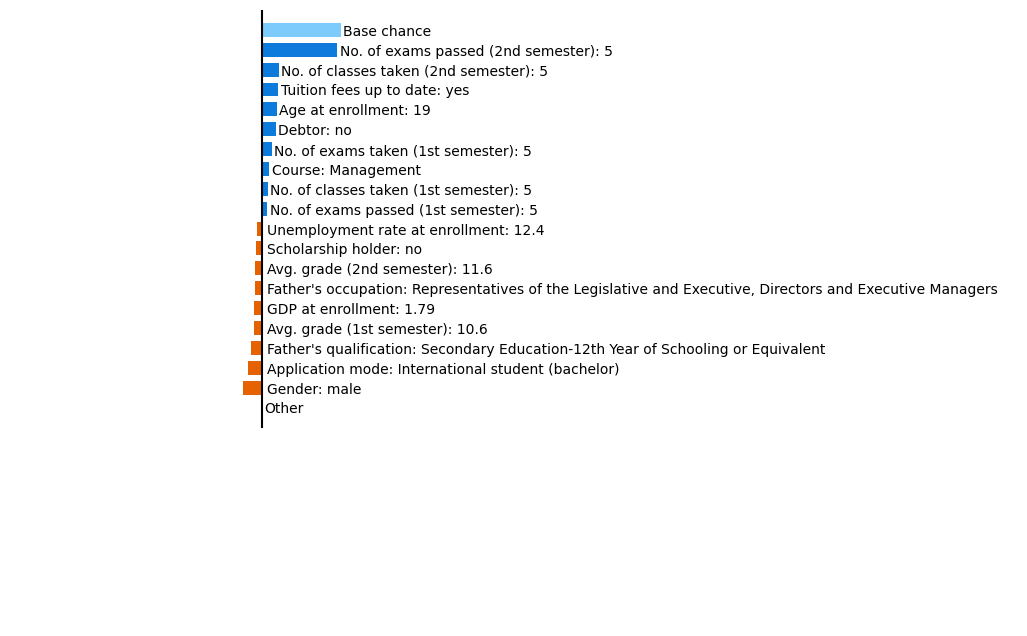

In [167]:
#print_example(shap_lookup[1409], id = 1409)
visualize_example(shap_lookup[1409], save = True, id = "test_1409")

## Find large variety of top features

In [110]:
df_x["id_raw"] = raw_indices
df_x["top_feature_1"] = top_features_1
df_x["top_feature_2"] = top_features_2
df_x["top_feature_3"] = top_features_3
df_x

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,grad_chance,id_raw,top_feature_1,top_feature_2,top_feature_3
1091,1,8,3,15,1,1,1,13,14,6,...,0.000000,0,8.9,1.4,3.51,0.003468,0,No. of exams passed (2nd semester),No. of exams passed (1st semester),Avg. grade (2nd semester)
902,1,4,1,12,1,3,1,22,28,8,...,12.887500,0,9.4,-0.8,-3.12,0.966496,1,No. of exams passed (2nd semester),No. of exams passed (1st semester),Avg. grade (2nd semester)
1127,1,1,1,10,1,1,1,22,28,10,...,11.000000,0,10.8,1.4,1.74,0.271239,2,Tuition fees up to date,Debtor,No. of exams passed (2nd semester)
2751,1,12,1,14,1,9,1,1,27,4,...,13.500000,0,15.5,2.8,-4.06,0.977961,3,No. of exams passed (2nd semester),No. of exams passed (1st semester),Avg. grade (2nd semester)
1621,1,1,1,6,1,1,1,23,27,10,...,13.000000,0,10.8,1.4,1.74,0.943988,4,No. of exams passed (2nd semester),No. of exams passed (1st semester),No. of classes taken (2nd semester)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,1,8,1,12,1,1,1,13,1,5,...,13.116667,0,7.6,2.6,0.32,0.987931,1810,No. of exams passed (2nd semester),No. of exams passed (1st semester),Avg. grade (2nd semester)
2273,2,1,4,3,0,1,1,19,24,1,...,0.000000,0,9.4,-0.8,-3.12,0.100089,1811,No. of exams passed (2nd semester),No. of exams passed (1st semester),Course
1012,1,8,1,9,1,1,1,1,28,5,...,12.000000,0,12.7,3.7,-1.70,0.980826,1812,No. of exams passed (2nd semester),Tuition fees up to date,Avg. grade (2nd semester)
3257,2,12,1,4,1,12,1,22,14,10,...,12.666667,0,11.1,0.6,2.02,0.731848,1813,No. of exams passed (2nd semester),Debtor,Avg. grade (2nd semester)


In [125]:
even_sample_top1 = []
even_sample_top2 = []
even_sample_top3 = []

dfg_x_1 = df_x.groupby("top_feature_1")
for feature, frame in dfg_x_1:
    print(feature)
    #print(frame.shape)
    found = False
    seen = []
    options = list(frame.index)
    probabilities = []
    for i in options:
        all_p = shap_lookup[i]["features"]
        this_p = [abs(p[2]) for p in shap_lookup[i]["features"] if p[0] == feature]
        assert len(this_p)==1
        p = this_p[0]
        probabilities.append(p)
    
    p_sum = sum(probabilities)
    probabilities = [p/p_sum for p in probabilities]

    while not found:
        example = np.random.choice(options, p = probabilities)
        if not example in even_sample_top1: 
            even_sample_top1.append(example)
            found = True
            print(example)
        else:
            seen.append(example)
            options.remove(example)
        if len(options)==0:
            found = True

even_sample_top2 = even_sample_top1.copy()
even_sample_top3 = even_sample_top1.copy()

dfg_x_2 = df_x.groupby("top_feature_2")
for feature, frame in dfg_x_2:
    #print(feature)
    #print(frame.shape)
    found = False
    seen = []
    options = list(frame.index)
    probabilities = []
    for i in options:
        all_p = shap_lookup[i]["features"]
        this_p = [abs(p[2]) for p in shap_lookup[i]["features"] if p[0] == feature]
        assert len(this_p)==1
        p = this_p[0]
        probabilities.append(p)
    
    #probabilities = [shap_lookup[i]["features"][feature] for i in options]
    p_sum = sum(probabilities)
    probabilities = [p/p_sum for p in probabilities]

    while not found:
        example = np.random.choice(options, p = probabilities)
        if not example in even_sample_top2: 
            even_sample_top2.append(example)
            found = True
        else:
            seen.append(example)
            options.remove(example)
        if len(options)==0:
            found = True

even_sample_top3 = even_sample_top2.copy()

dfg_x_3 = df_x.groupby("top_feature_3")
for feature, frame in dfg_x_3:
    #print(feature)
    #print(frame.shape)
    found = False
    seen = []
    options = list(frame.index)
    probabilities = []
    for i in options:
        all_p = shap_lookup[i]["features"]
        this_p = [abs(p[2]) for p in shap_lookup[i]["features"] if p[0] == feature]
        assert len(this_p)==1
        p = this_p[0]
        probabilities.append(p)
    
    #probabilities = [shap_lookup[i]["features"][feature] for i in options]
    p_sum = sum(probabilities)
    probabilities = [p/p_sum for p in probabilities]

    while not found:
        example = np.random.choice(options, p = probabilities)
        if not example in even_sample_top3: 
            even_sample_top3.append(example)
            found = True
        else:
            seen.append(example)
            options.remove(example)
        if len(options)==0:
            found = True

print(even_sample_top1, len(even_sample_top1))
print(even_sample_top2, len(even_sample_top2))
print(even_sample_top3, len(even_sample_top3))

Age at enrollment
1042
Application mode
3988
Avg. grade (2nd semester)
3576
Course
872
Debtor
3207
Gender
2692
No. of exams passed (1st semester)
3027
No. of exams passed (2nd semester)
2609
Tuition fees up to date
1833
[1042, 3988, 3576, 872, 3207, 2692, 3027, 2609, 1833] 9
[1042, 3988, 3576, 872, 3207, 2692, 3027, 2609, 1833, 3224, 1125, 3709, 2980, 262, 1409, 1050, 2309, 2642, 629, 2870, 4421, 503] 22
[1042, 3988, 3576, 872, 3207, 2692, 3027, 2609, 1833, 3224, 1125, 3709, 2980, 262, 1409, 1050, 2309, 2642, 629, 2870, 4421, 503, 2358, 487, 3647, 3245, 3151, 223, 758, 68, 66, 3278, 533, 3369, 3676, 3588, 4107] 37


### Generate Vis X for chosen examples

Student 1042

Predicted likelihood to graduate: 0.624559194322715

Factors: 
No. of exams passed (2nd semester): 5	0.10666965988808187
No. of exams passed (1st semester): 8	0.09993702077504558
Tuition fees up to date: yes	0.03372662727112627
Debtor: no	0.0282848703940493
GDP at enrollment: -3.12	0.026307058308491945
Unemployment rate at enrollment: 9.4	0.019829096446950436
Father's qualification: Basic education 1st cycle (4th/5th year) or equivalent	0.015493215138907244
Gender: female	0.014869678098380197
Father's occupation: Farmers and Skilled Workers in Agriculture, Fisheries, and Forestry	0.013107660817741786
No. of exams taken (2nd semester): 12	-0.010770877791296951
No. of exams taken (1st semester): 8	-0.013149350900430533
No. of classes taken (1st semester): 8	-0.014604540144467963
No. of classes taken (2nd semester): 7	-0.016168781435955216
Scholarship holder: no	-0.016599751099333402
No. of classes credited from previous education/work (1st semester): 4	-0.020989080837125057

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


---------------------------------------------------------------------
Student 2358

Predicted likelihood to graduate: 0.8320752733878265

Factors: 
No. of exams passed (2nd semester): 6	0.16367240177850867
No. of exams passed (1st semester): 6	0.08280878531117794
Avg. grade (2nd semester): 14.6	0.04691547773804996
Course: Agronomy	0.035673789820341695
Tuition fees up to date: yes	0.03439257015635377
Debtor: no	0.021066978813723738
Avg. grade (1st semester): 15.12	0.013452667475082917
No. of exams taken (1st semester): 8	-0.010054904142780072
Scholarship holder: no	-0.012134862052090932
Unemployment rate at enrollment: 16.2	-0.012427311501069002
Mother's occupation: Specialists in Intellectual and Scientific Activities	-0.012687051363469853
No. of classes taken (2nd semester): 6	-0.014825847493593801
Father's qualification: Higher Education-degree	-0.015038429486896066
Gender: male	-0.01609282120144516
Father's occupation: Specialists in Intellectual and Scientific Activities	-0.0216487

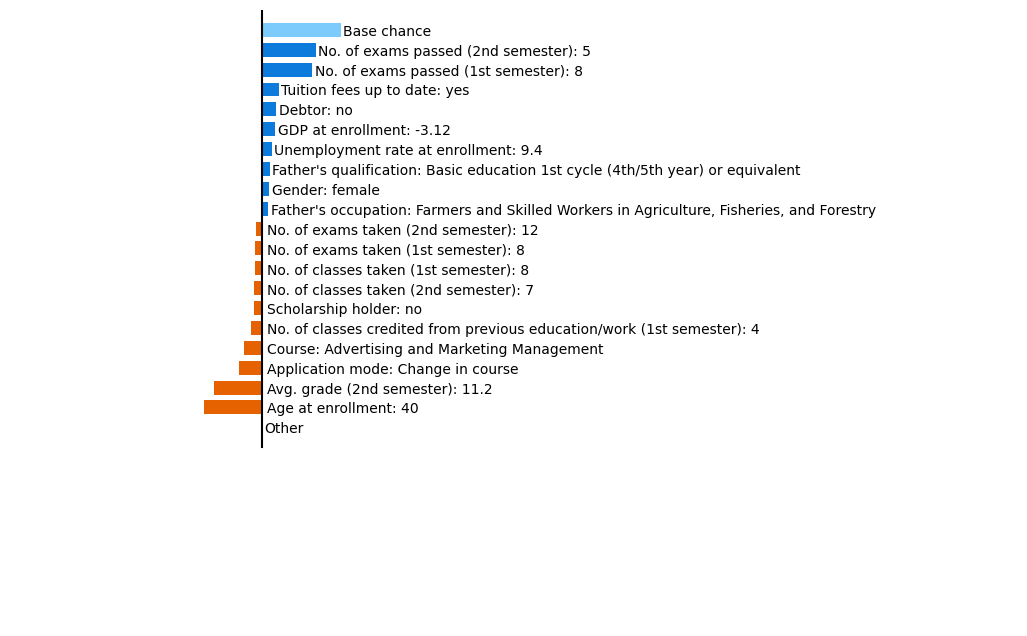

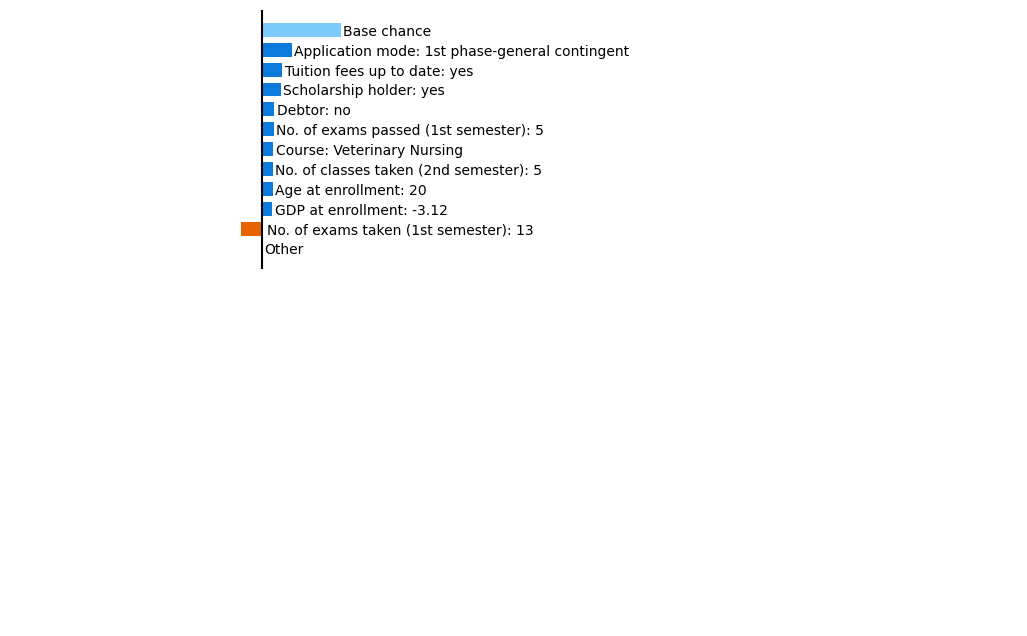

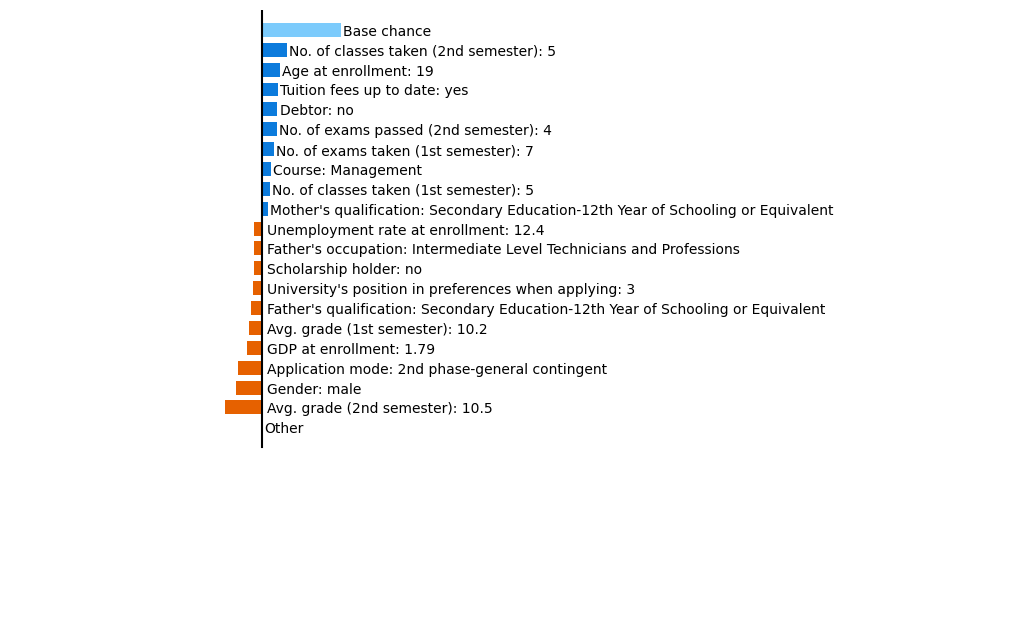

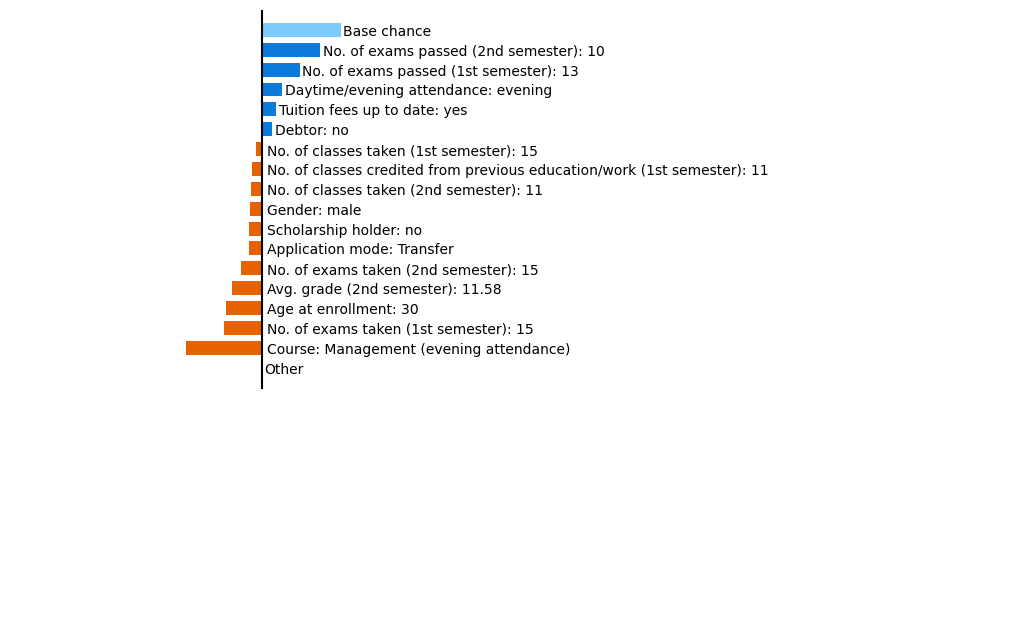

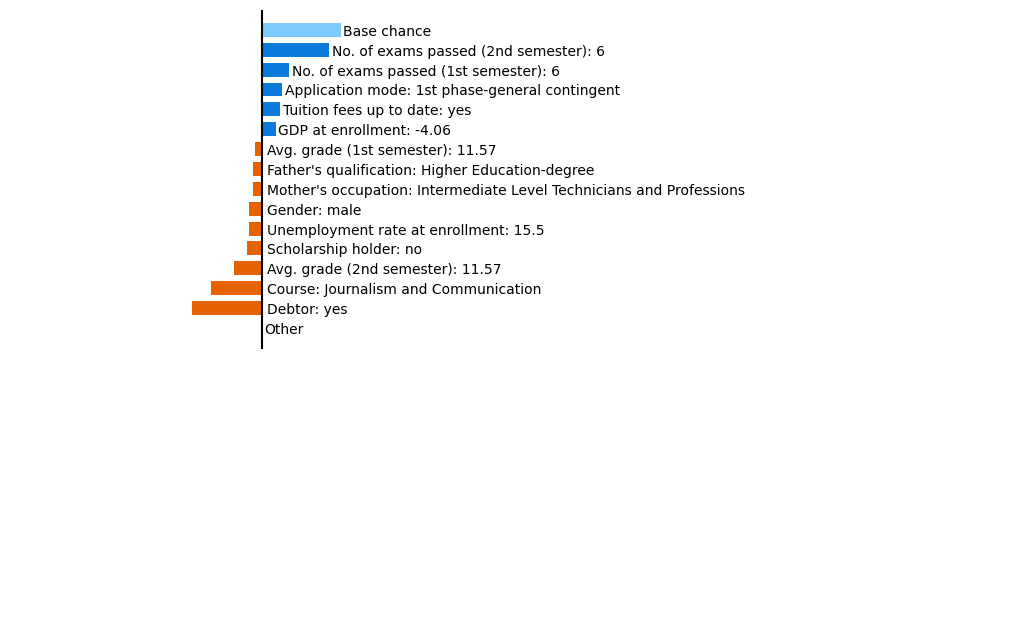

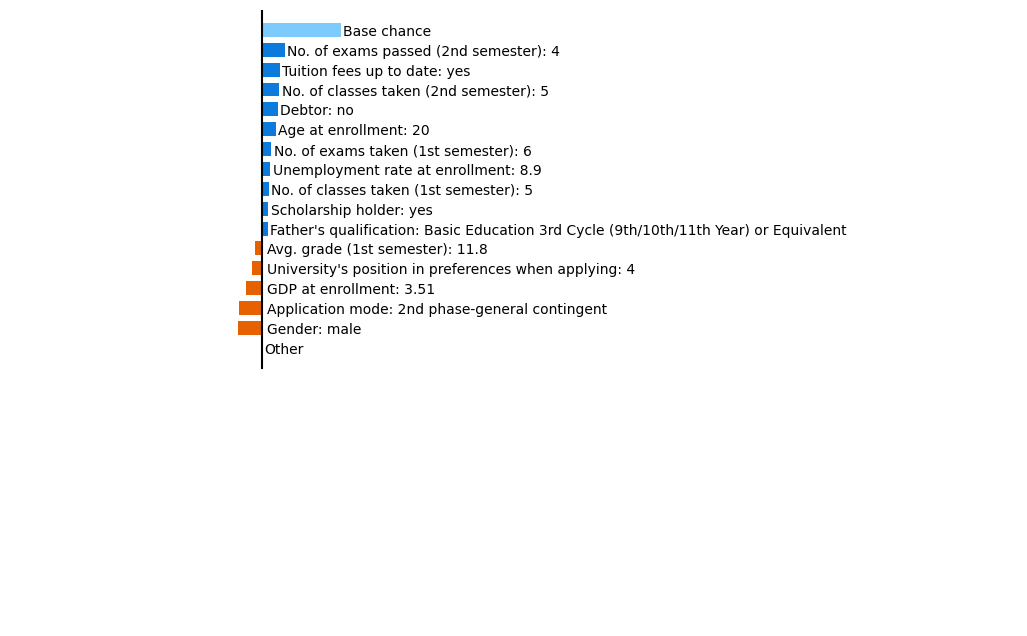

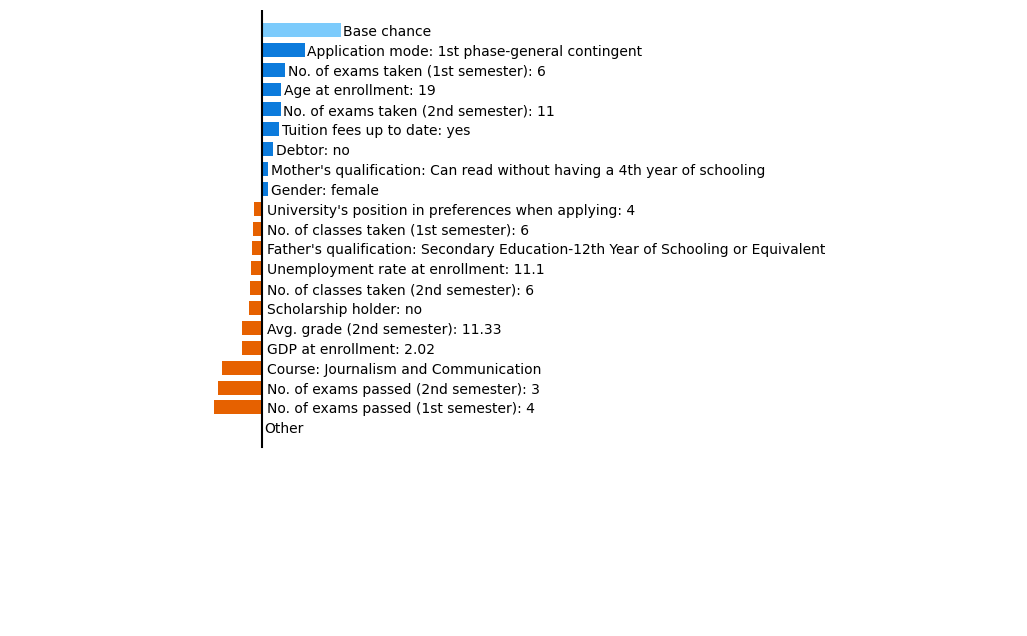

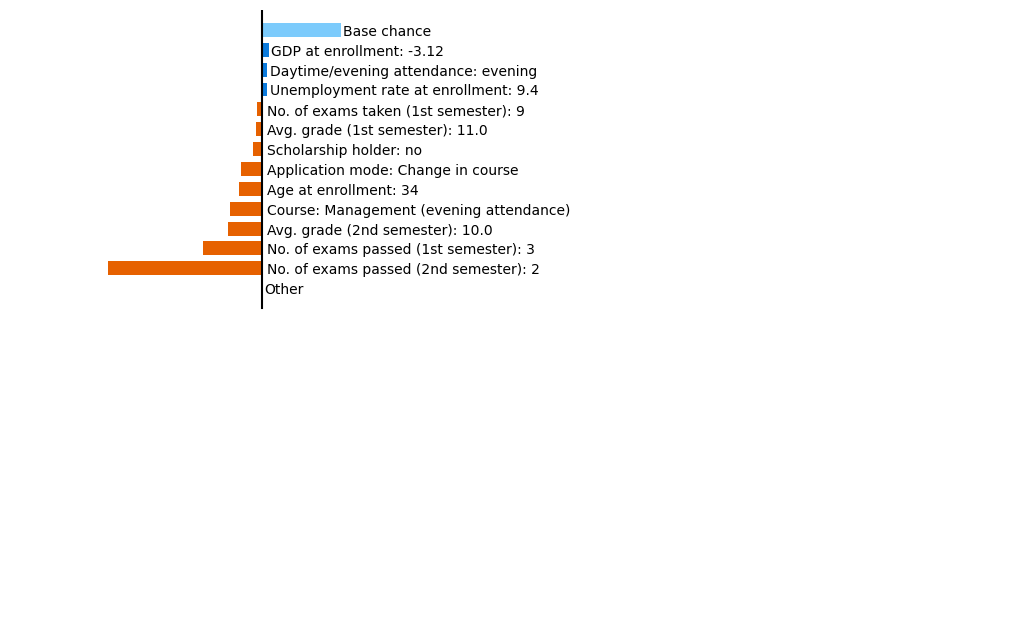

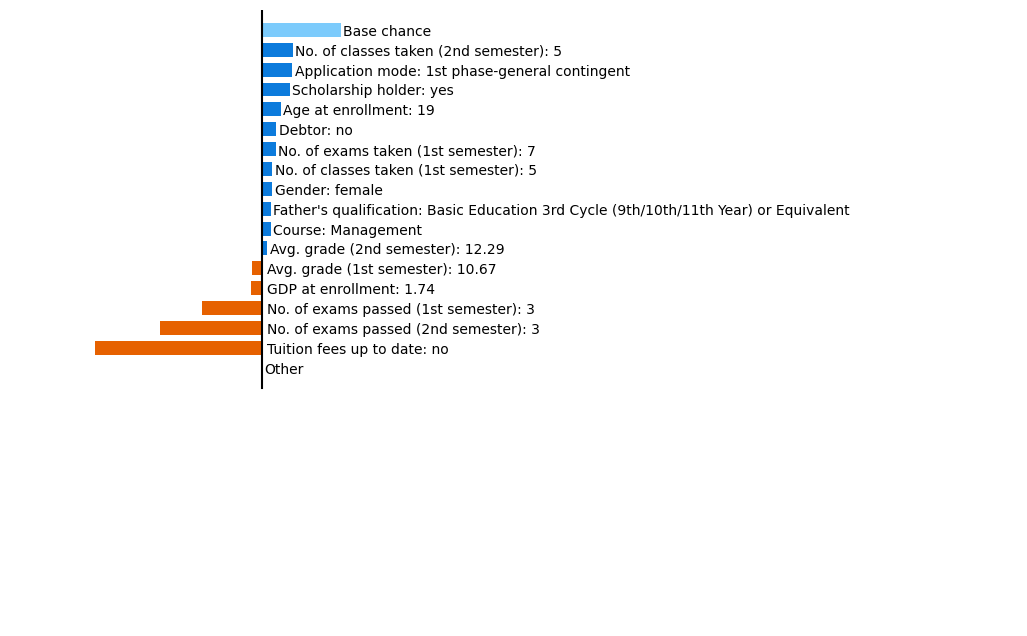

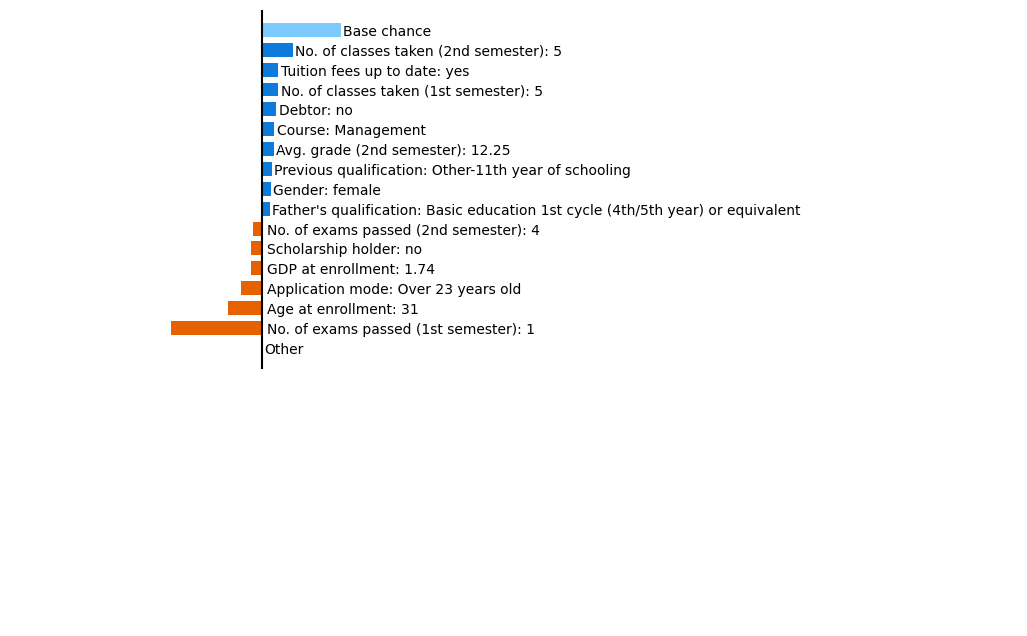

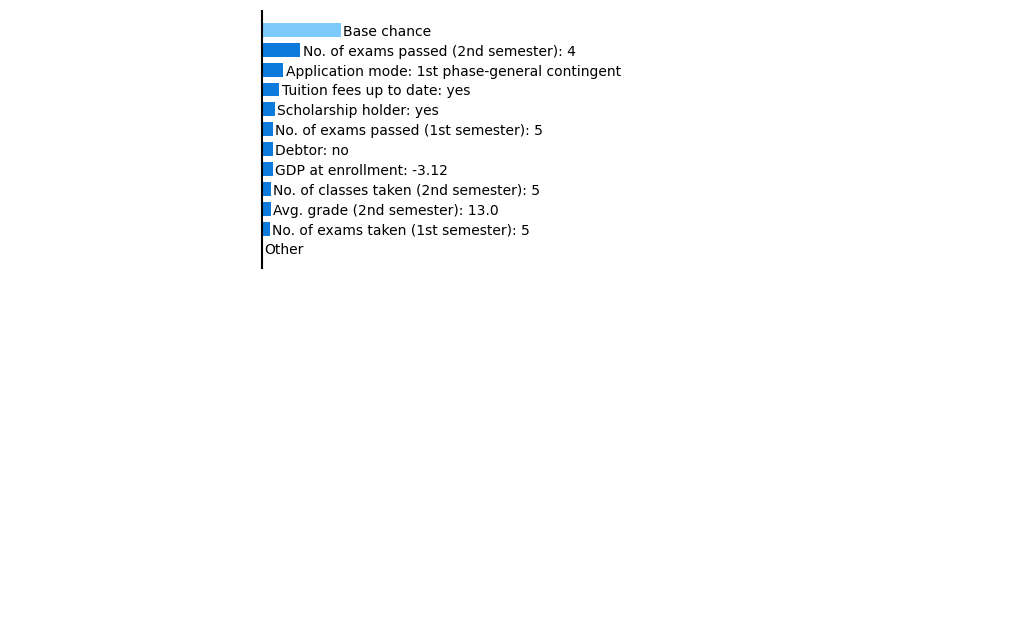

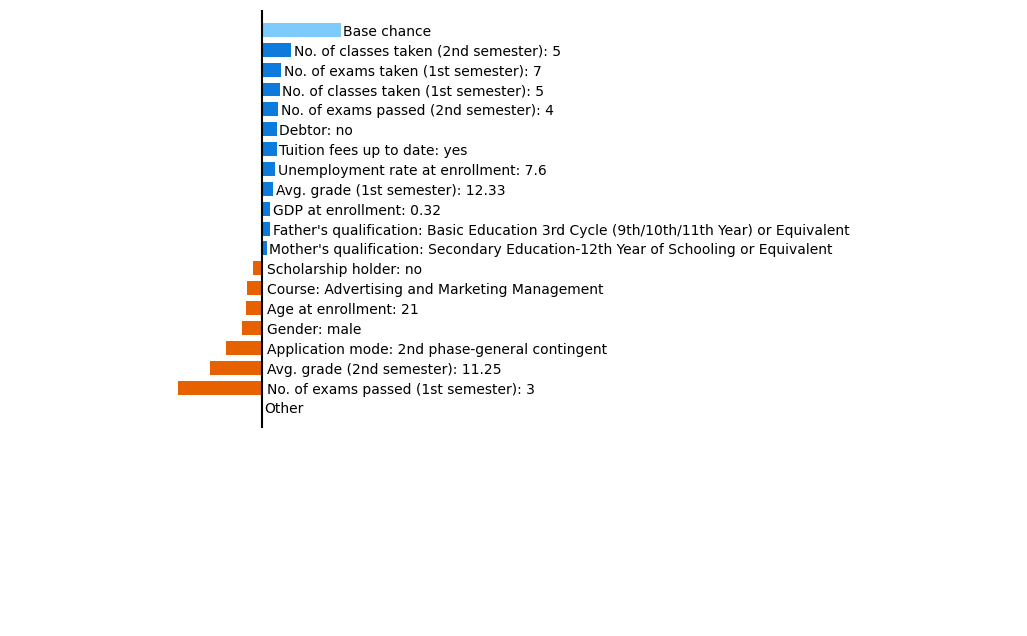

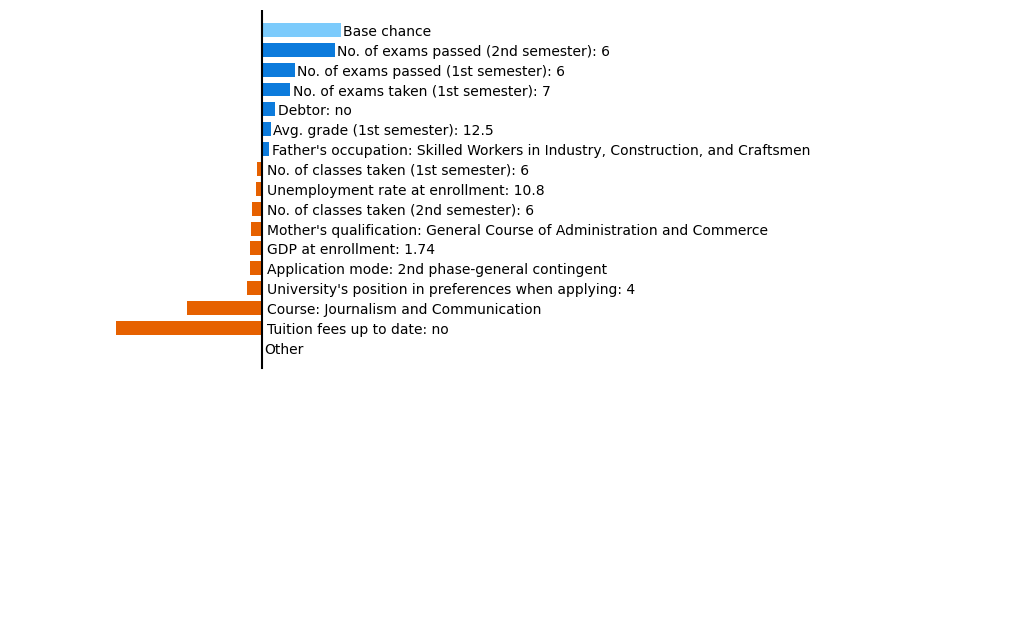

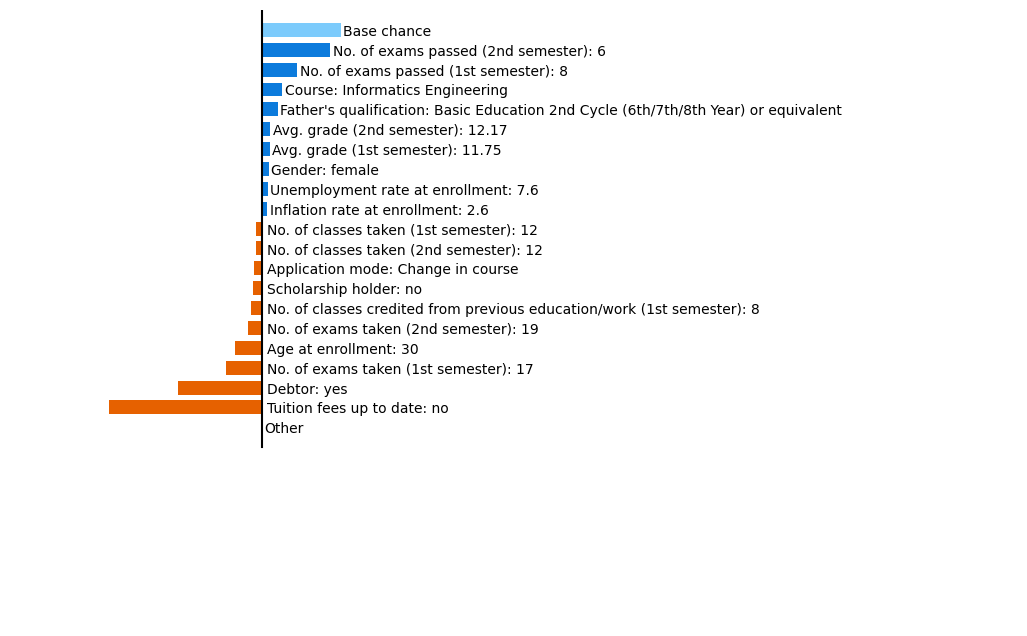

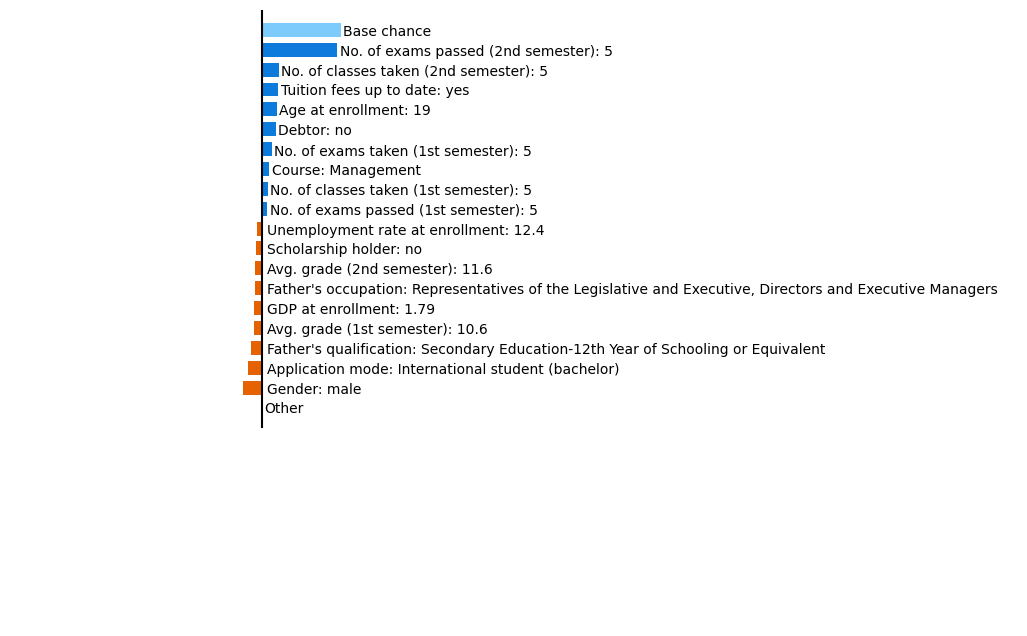

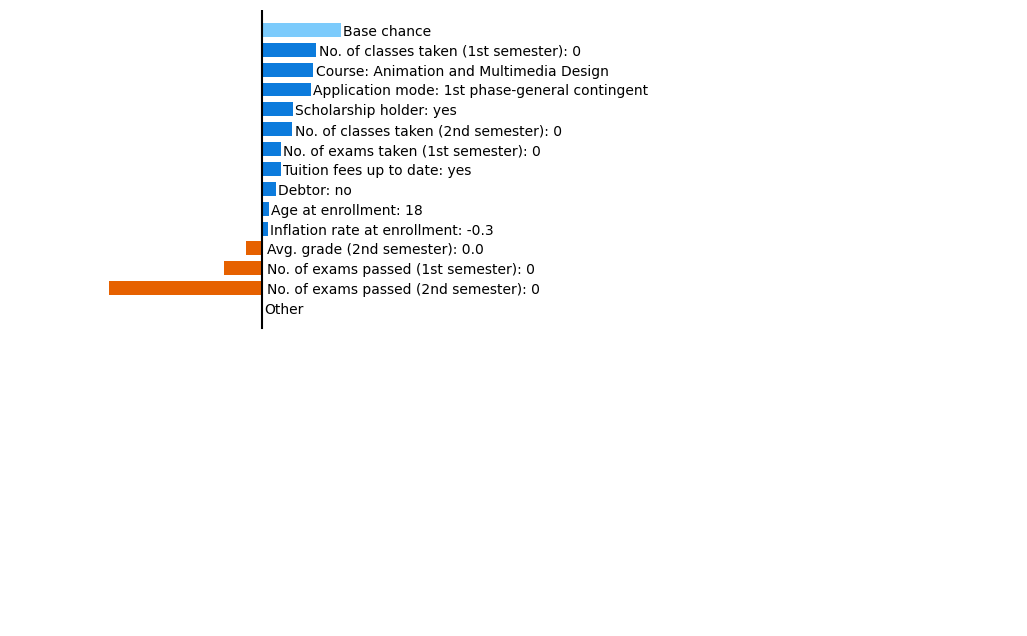

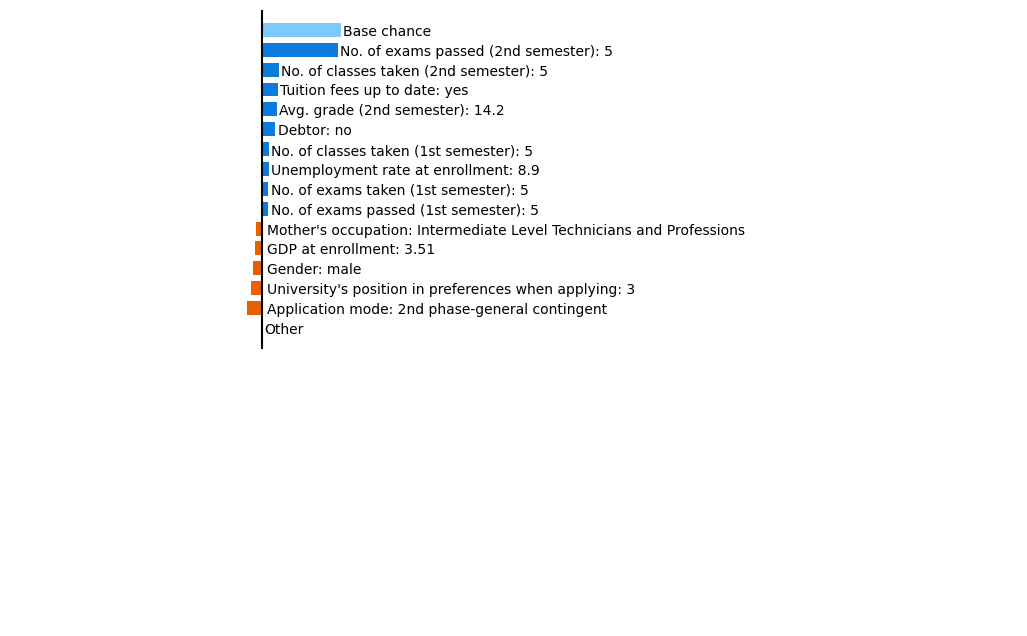

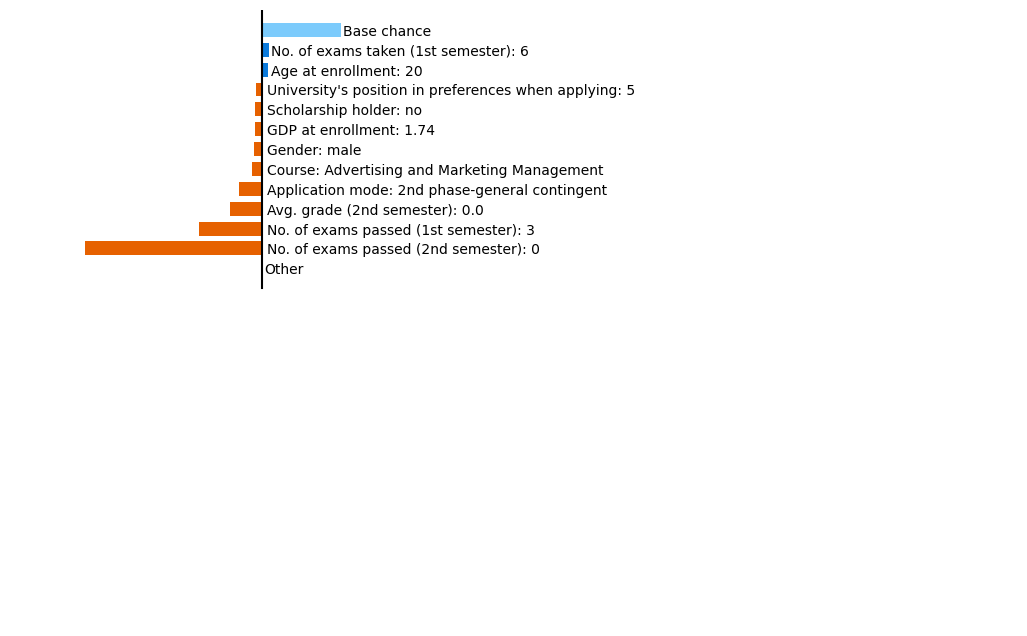

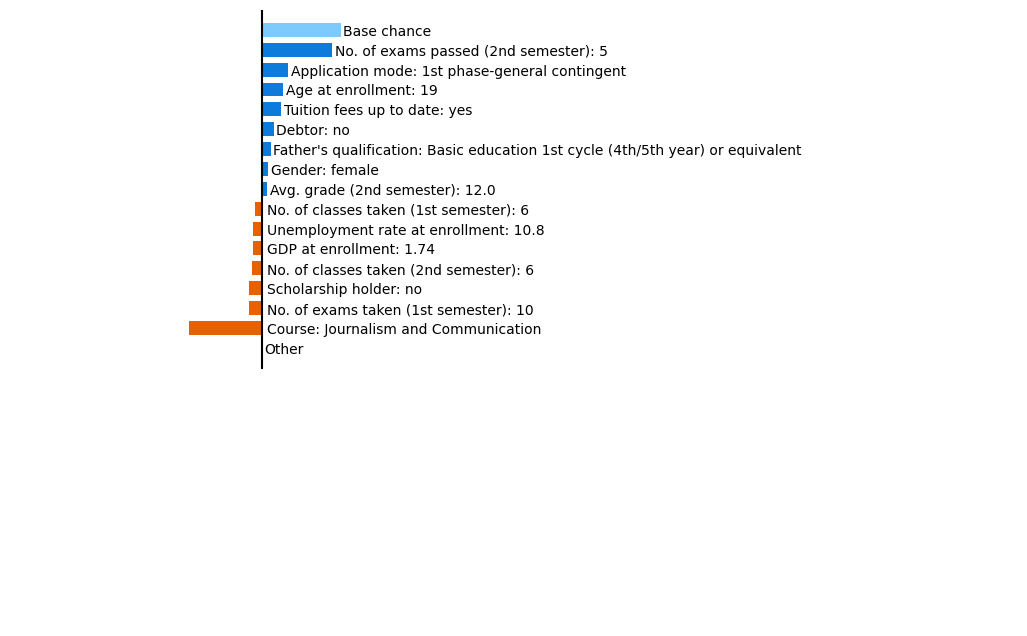

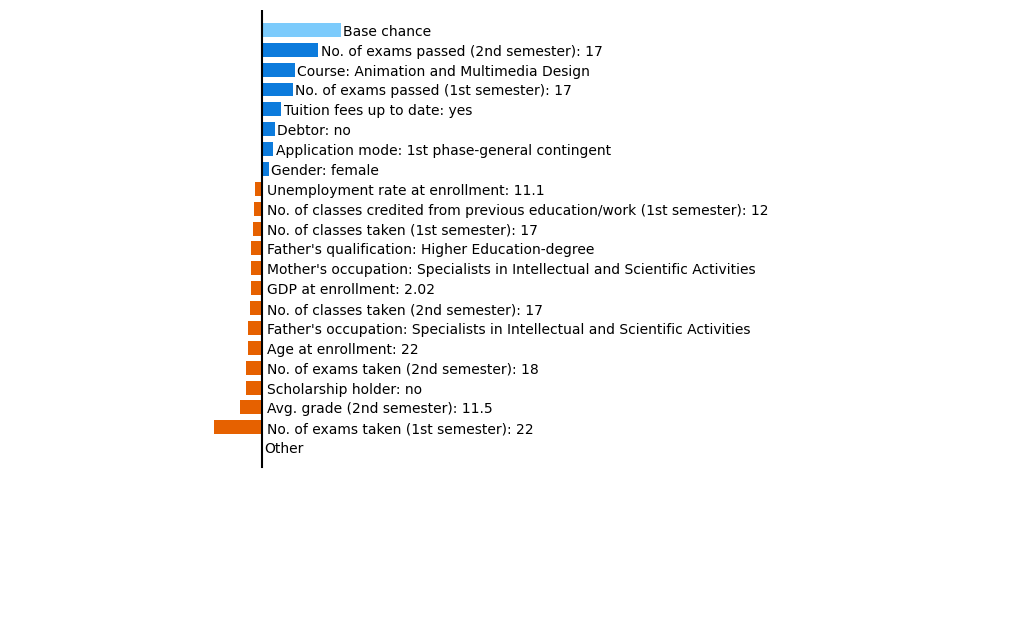

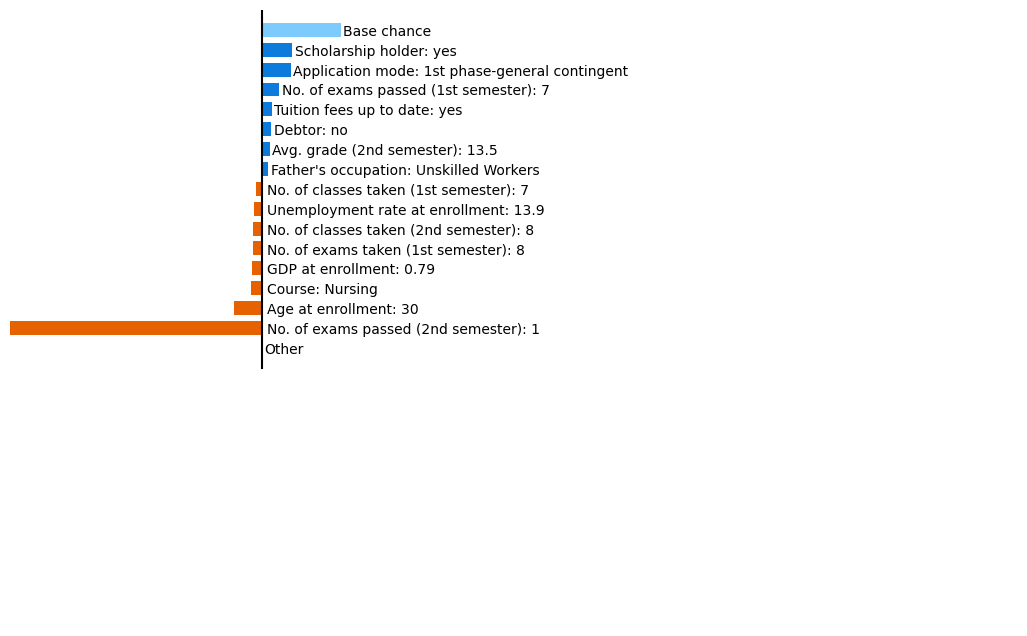

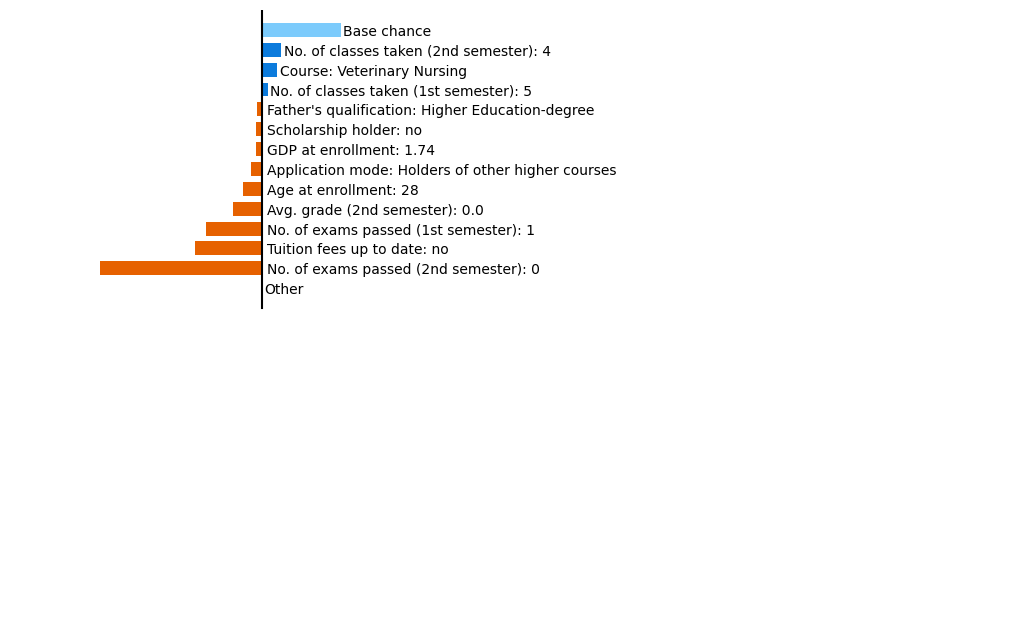

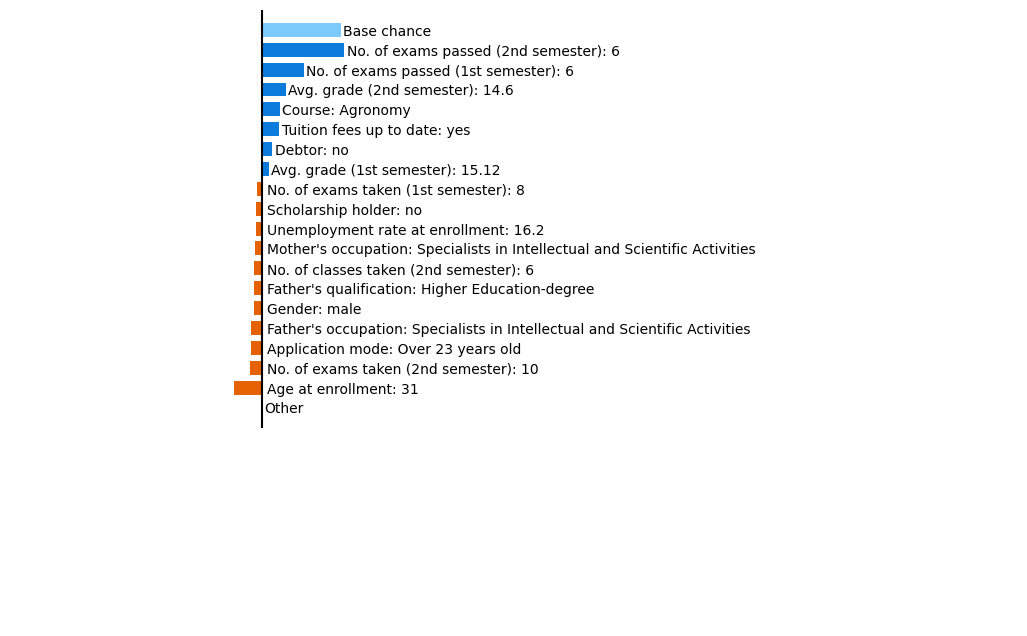

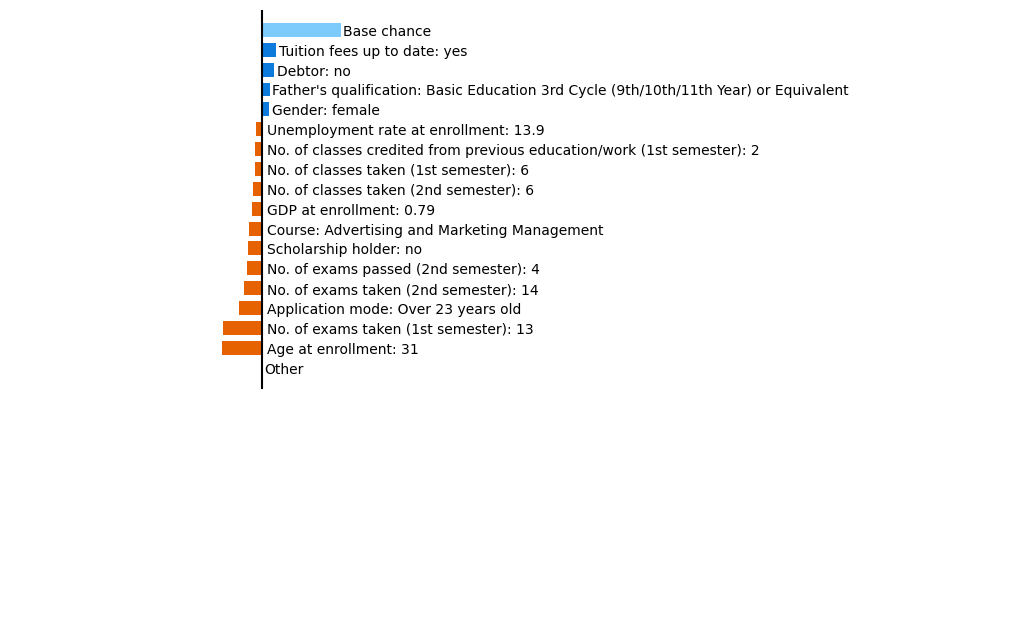

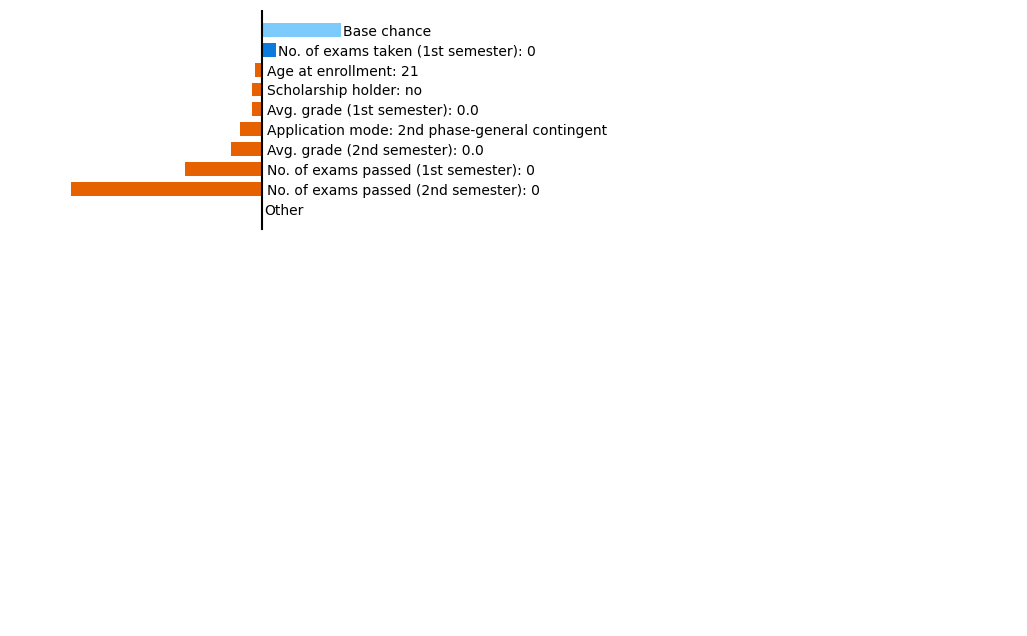

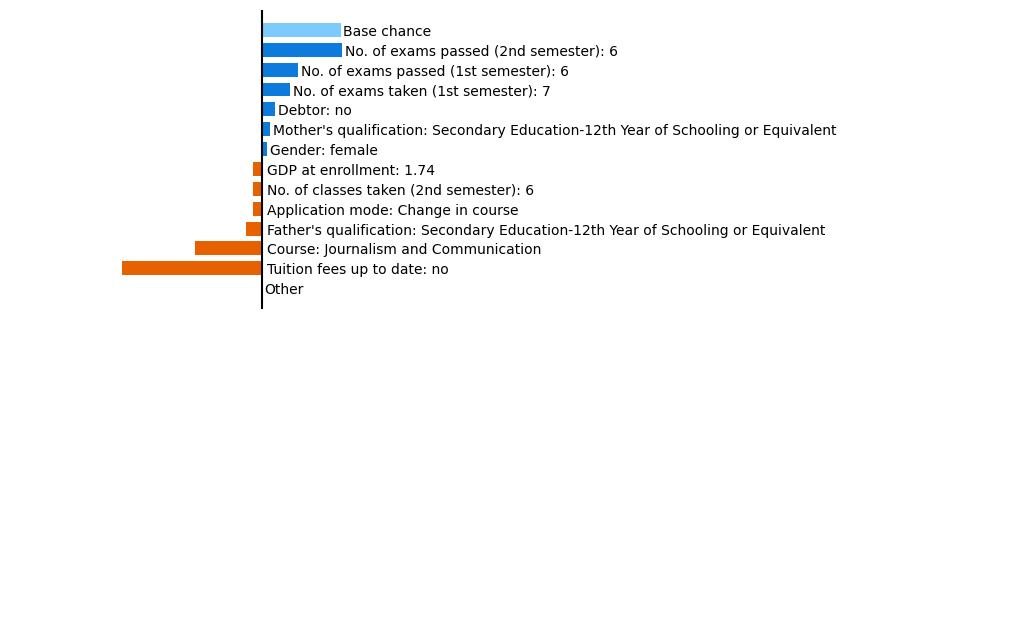

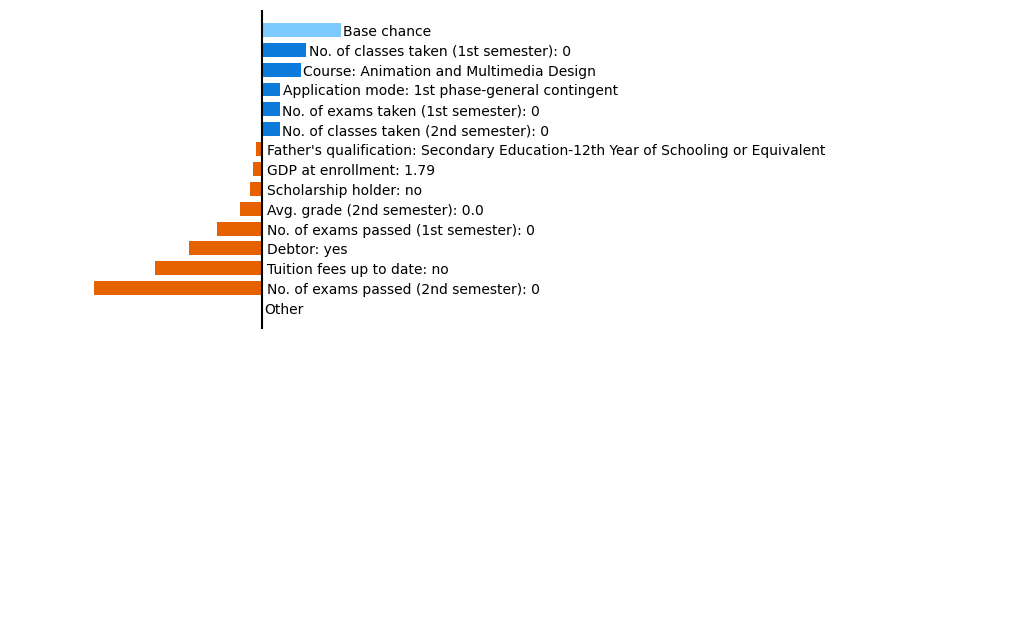

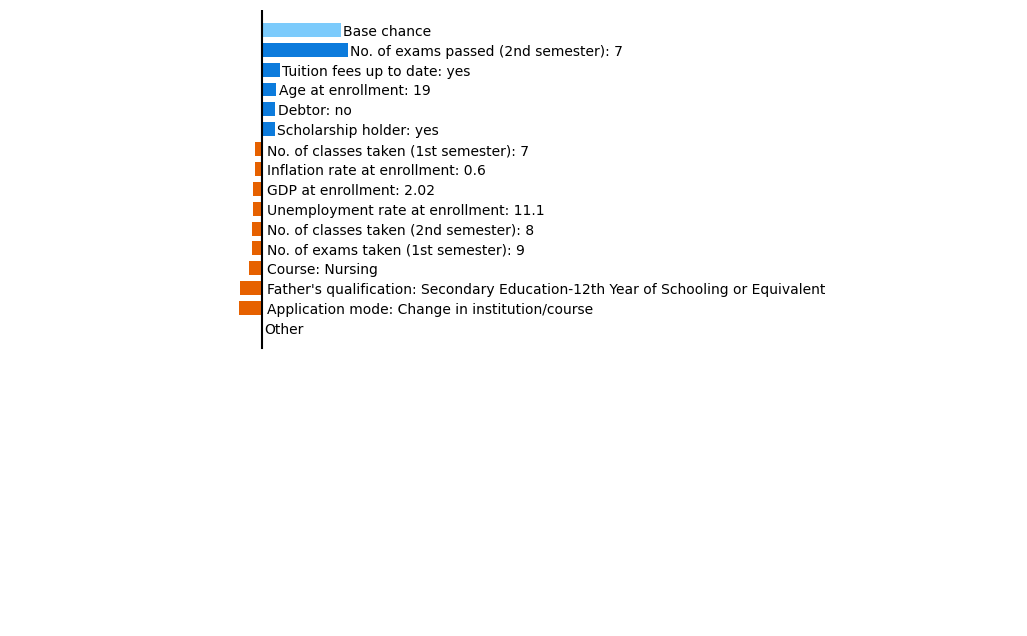

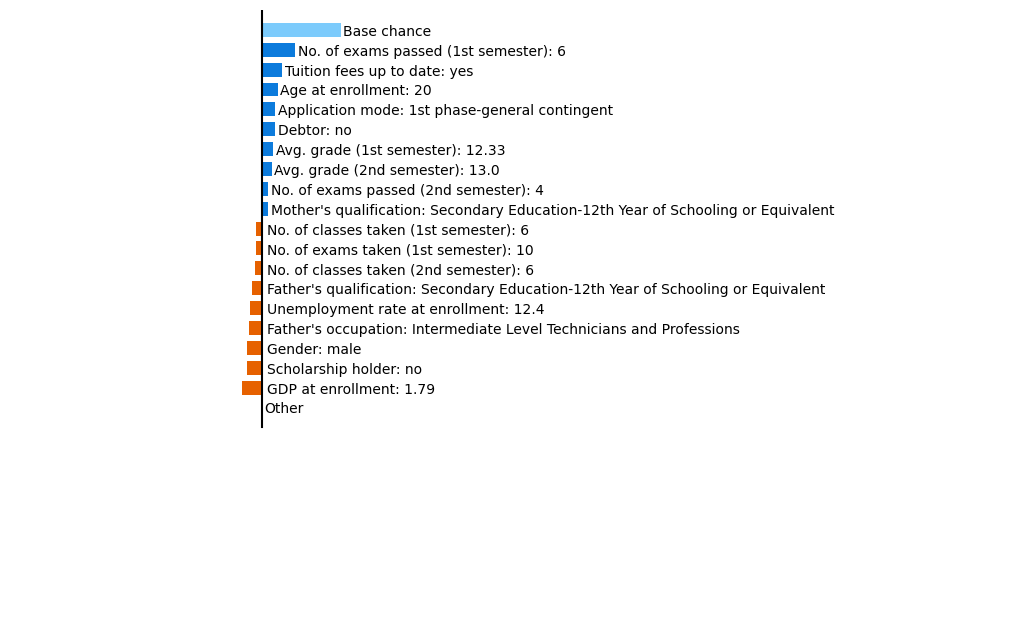

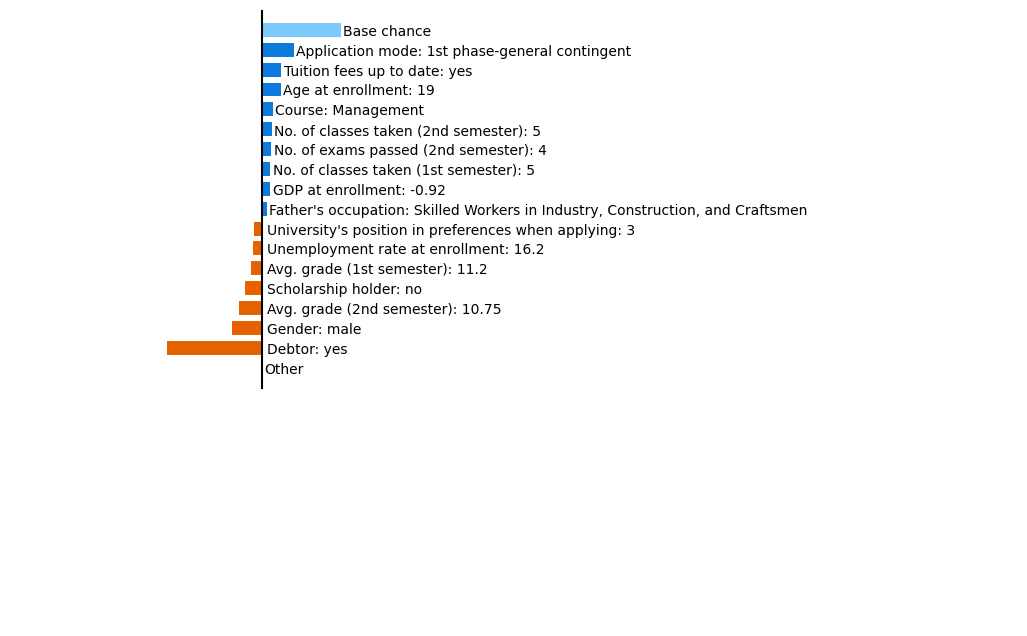

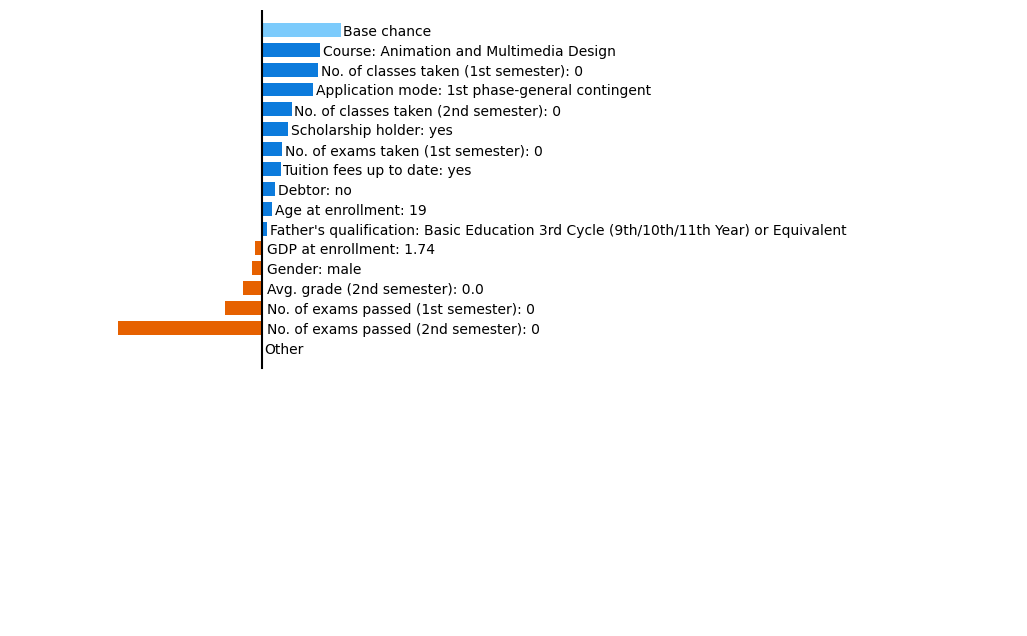

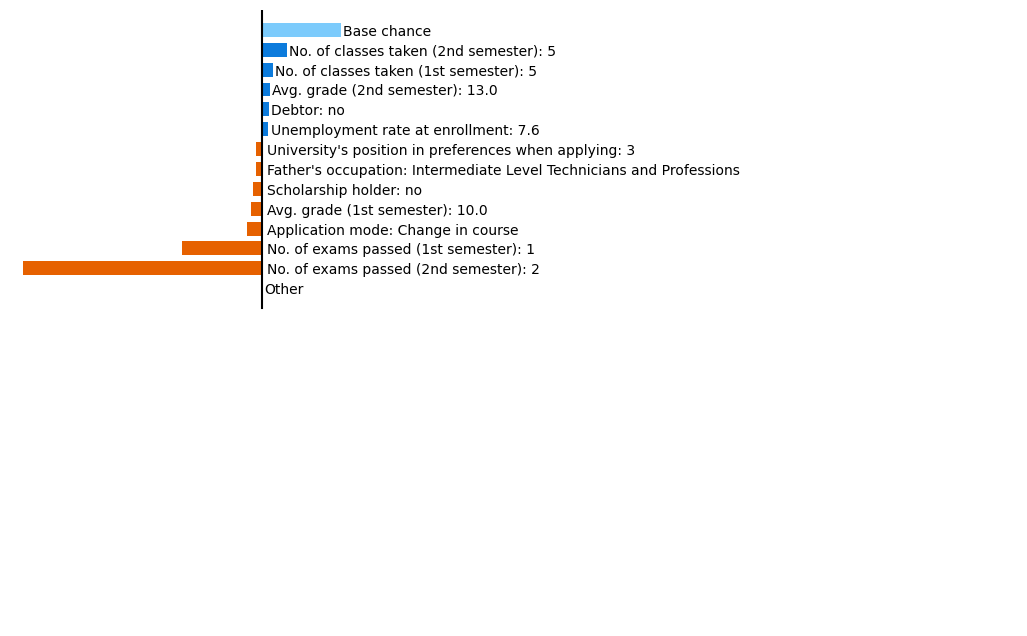

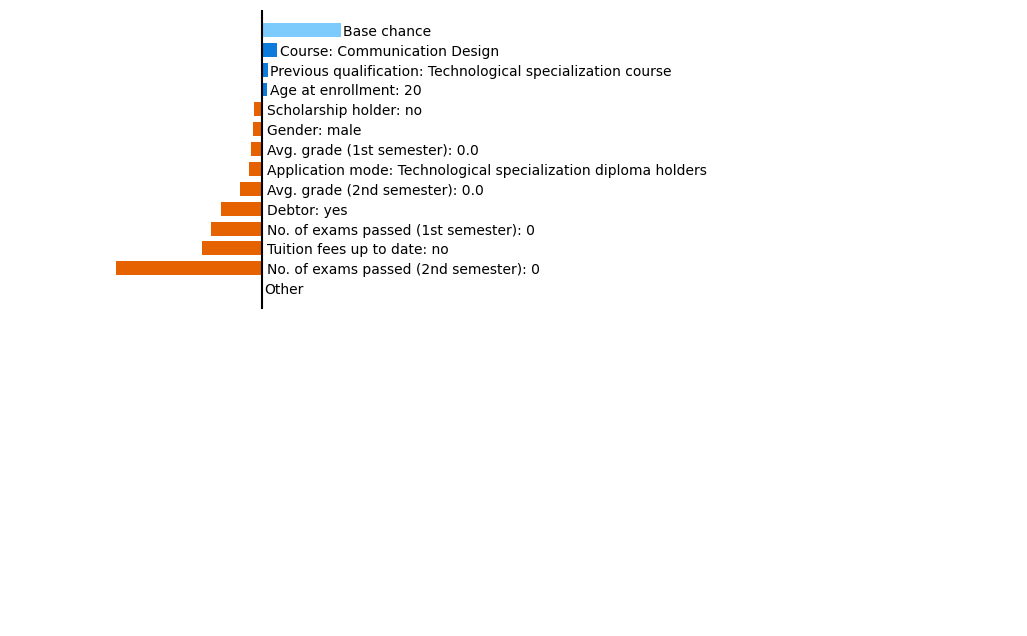

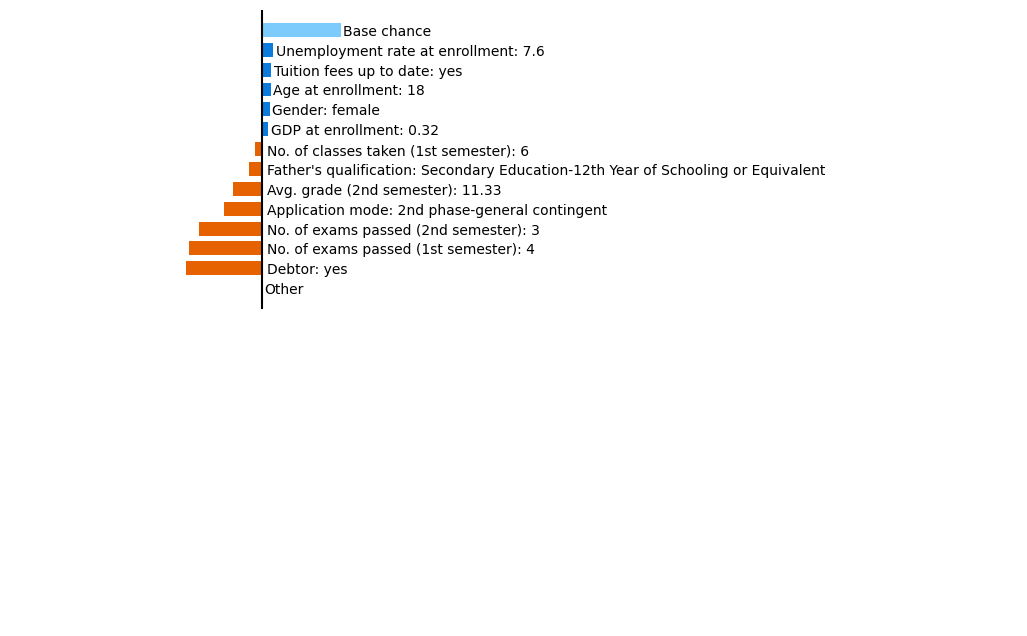

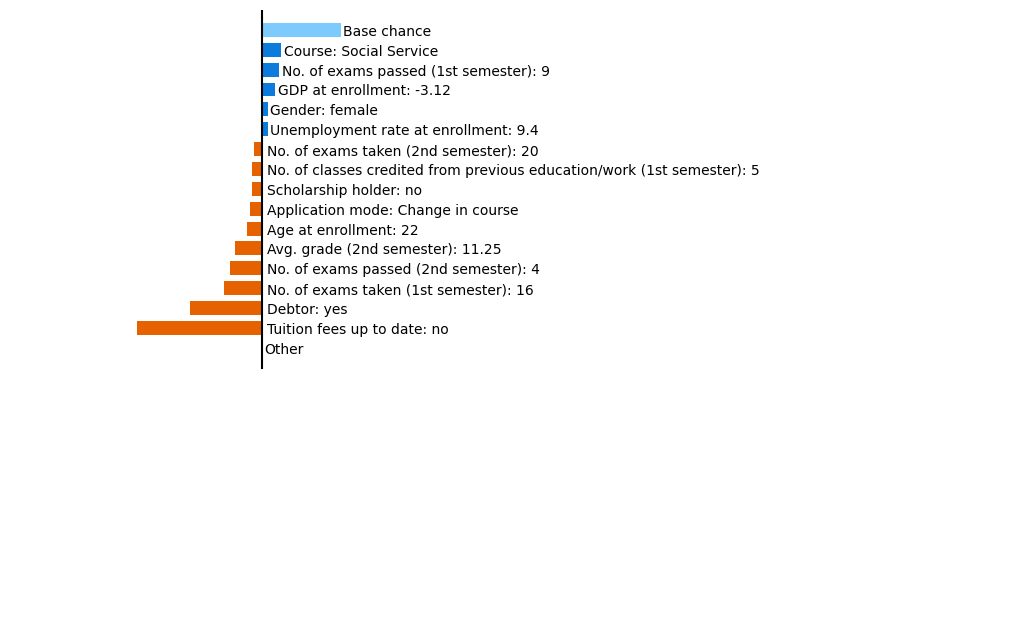

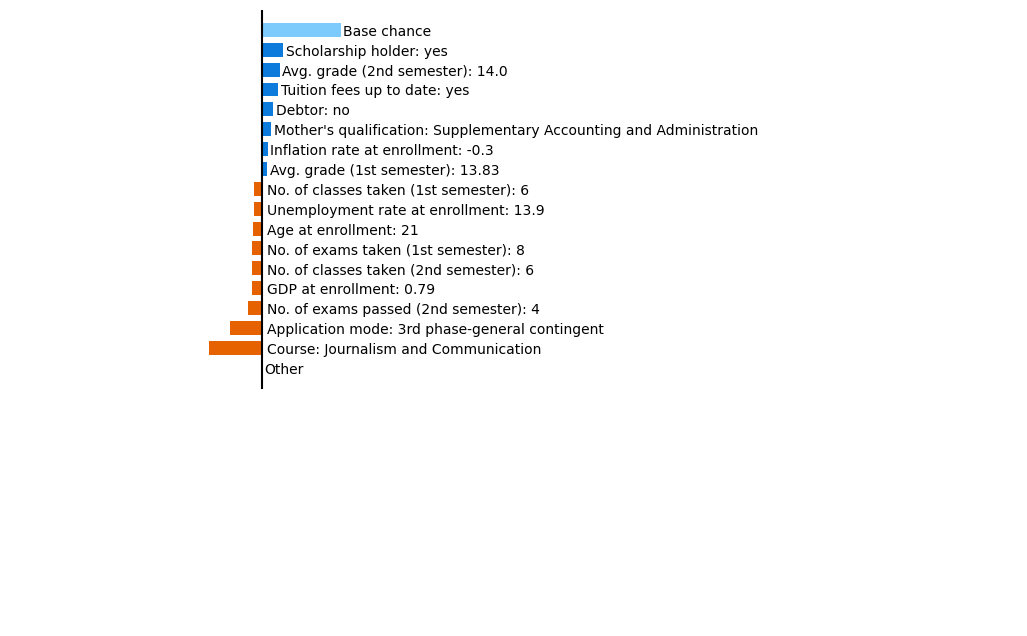

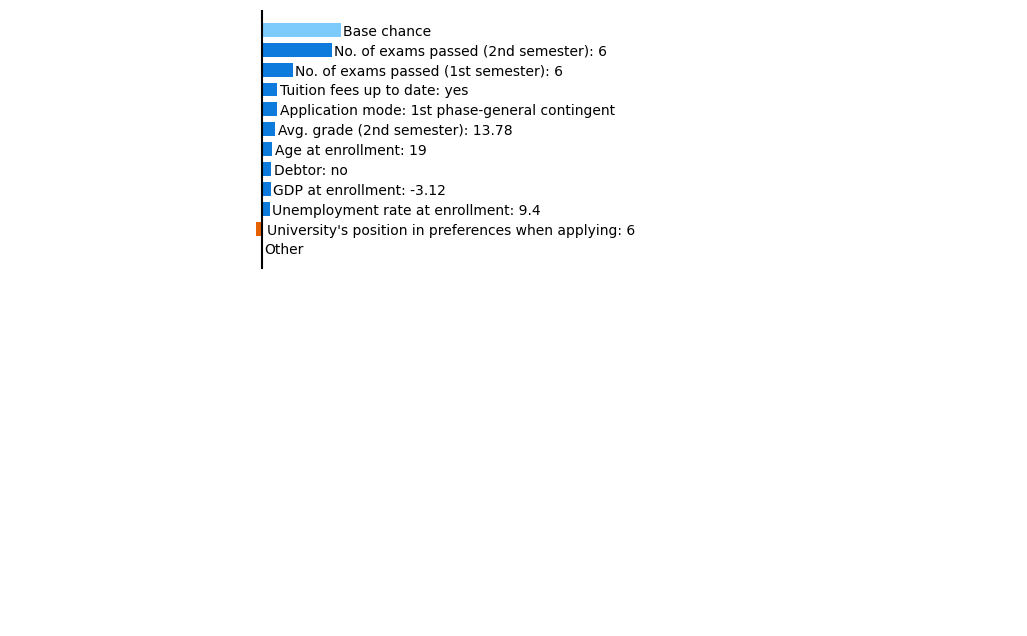

In [173]:
explanations_data = {}

for example in even_sample_top3:
    if example in even_sample_top1:
        top = 1
    elif example in even_sample_top2:
        top = 2
    else:
        top = 3
    text_data = print_example(shap_lookup[example], id = example)
    explanations_data[str(example)] = {"top":top, "data":text_data}
    check = visualize_example(shap_lookup[example], save = True, id = example)
    assert check
    print("---------------------------------------------------------------------")

In [174]:
with open('explanations.json', 'w') as fp:
    json.dump(explanations_data, fp)